In [1]:
# loading and installing packages
if (system.file(package='grid') == '') install.packages('grid')
if (system.file(package='gtable') == '') install.packages('gtable')
if (system.file(package='gridExtra') == '') install.packages('gridExtra')
if (system.file(package='ggpubr') == '') install.packages('ggpubr')
if (system.file(package='ggpp') == '') install.packages('ggpp')
if (system.file(package='gridtext') == '') install.packages('gridtext')
if (system.file(package='jsonlite') == '') install.packages('jsonlite')
if (system.file(package='dplyr') == '') install.packages('dplyr')
if (system.file(package='ggplot2') == '') install.packages('ggplot2')
require(gridExtra)
require(grid)
require(gtable)
require(jsonlite)
require(dplyr)
require(ggplot2)
require(ggpubr)
require(ggpp)
require(gridtext)

Loading required package: gridExtra

Loading required package: grid

Loading required package: gtable

Loading required package: jsonlite

Loading required package: dplyr


Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: ggpp


Attaching package: 'ggpp'


The following object is masked from 'package:ggplot2':

    annotate


Loading required package: gridtext



In [2]:
# This is the helper function of to add transducer table
geom_table_costumized <- function(mapping = NULL, data = NULL,
                           stat = "identity", position = "identity",
                           ...,
                           table.theme = NULL,
                           table.rownames = FALSE,
                           table.colnames = TRUE,
                           table.hjust = 0.5,
                           parse = FALSE,
                           na.rm = FALSE,
                           show.legend = FALSE,
                           inherit.aes = FALSE) {

  if (is.character(table.hjust)) {
    table.hjust <- switch(table.hjust,
                          left = 0,
                          middle = 0.5,
                          center = 0.5,
                          right = 1,
                          0.5)
  }
  ggplot2::layer(
    data = data,
    mapping = mapping,
    stat = stat,
    geom = GeomTableNpcNew,
    position = position,
    show.legend = show.legend,
    inherit.aes = inherit.aes,
    params = list(
      table.theme = table.theme,
      table.rownames = table.rownames,
      table.colnames = table.colnames,
      table.hjust = table.hjust,
      parse = parse,
      na.rm = na.rm,
      ...
    )
  )
}

#' @rdname ggpp-ggproto
#' @format NULL
#' @usage NULL
#' @export
GeomTableNpcNew <-
  ggplot2::ggproto("GeomTableNpc", ggplot2::Geom,
                   required_aes = c("npcx", "npcy", "label","text", "title_text","subtitle","leftShift", "fs","shrinkPadding","titleFont"),

                   default_aes = ggplot2::aes(
                     colour = NA,
                     fill = NA,
                     size = 3.2,
                     angle = 0,
                     hjust = "inward",
                     vjust = "inward",
                     alpha = 1,
                     family = "",
                     fontface = 1,
                     lineheight = 1.2
                   ),

                   draw_panel =
                     function(data,
                              panel_params,
                              coord,
                              table.theme = NULL,
                              table.rownames = FALSE,
                              table.colnames = TRUE,
                              table.hjust = 0,
                              parse = FALSE,
                              na.rm = FALSE) {

                       if (nrow(data) == 0) {
                         return(grid::nullGrob())
                       }

                       if (!is.data.frame(data$label[[1]])) {
                         warning("Skipping as object mapped to 'label' is not a list of ",
                                 "\"tibble\" or \"data.frame\" objects.")
                         return(grid::nullGrob())
                       }

                       data$npcx <- compute_npcx(data$npcx, margin.npc = 0)-data$leftShift
                       data$npcy <- compute_npcy(data$npcy, margin.npc = 0)

                       if (is.character(data$vjust)) {
                         data$vjust <- compute_just(data$vjust, data$npcy)
                       }
                       if (is.character(data$hjust)) {
                         data$hjust <- compute_just(data$hjust, data$npcx)
                       }

                       # replace NULL with default
                       if (is.null(table.theme)) {
                         table.theme <-
                           getOption("ggpmisc.ttheme.default", default = ttheme_gtdefault)
                       }

                       tb.grobs <- grid::gList()

                       for (row.idx in seq_len(nrow(data))) {
                         # if needed, construct the table theme
                         if (is.function(table.theme)) {
                           # text position in cell depends on hjust
                           table.x <- if(table.hjust == 0.5) 0.5 else table.hjust * 0.8 + 0.1
                           if (is.na(data$fill[row.idx])) {
                             core.params <-
                               list(fg_params = list(hjust = 0, x = 0.1))
                           } else {
                             core.params <-
                               list(fg_params = list(hjust = 0, x = 0.1),
                                    bg_params = list(fill = data$fill[row.idx]))
                           }
                           if (is.na(data$colour[row.idx])) {
                             # use theme's default base_colour
                             this.table.theme <-
                               table.theme(base_size = data$size[row.idx] * .pt,
                                           base_family = data$family[[row.idx]],
                                           parse = parse,
                                           rowhead = list(fg_params = list(hjust = 0, x = 0.1)),
                                           colhead = list(fg_params = list(hjust = 0,
                                                                           x = 0.1)),
                                           core = core.params)
                           } else {
                             # use colour from data$colour
                             this.table.theme <-
                               table.theme(base_size = data$size[row.idx] * .pt,
                                           base_colour = ggplot2::alpha(data$colour[row.idx],
                                                                        data$alpha[row.idx]),
                                           base_family = data$family[[row.idx]],
                                           parse = parse,
                                           rowhead = list(fg_params = list(hjust = 0, x = 0.1)),
                                           colhead = list(fg_params = list(hjust = 0,
                                                                           x = 0.1)),
                                           core = core.params)
                           }
                         } else if (is.list(table.theme)) {
                           this.table.theme <- table.theme
                         }
                         table.tb <- data[["label"]][[row.idx]]
                         gtb <-
                           gridExtra::tableGrob(
                             d = table.tb,
                             theme = this.table.theme,
                             rows = if (table.rownames) rownames(table.tb) else NULL,
                             cols = if (table.colnames) colnames(table.tb) else NULL
                           )

                         ## my customized code
                         shrinkPadding <- data[["shrinkPadding"]][[1]]

                         fs = data[["fs"]][[1]]
                         title_text <- gridtext::richtext_grob(data[["title_text"]], x=0.03, hjust=0, gp=gpar(fontsize=fs, fontface = data[["titleFont"]][[1]]))
                         row_to_add <- list()
                         if (data[["title_text"]][[1]] != "") {
                           row_to_add <- list(title_text)
                           gtb <- gtable_add_rows(gtb,
                                                  heights = grobHeight(title_text) + unit(0.2,"line"),
                                                  pos = 0)
                           index = 2
                         } else {
                           index = 1
                         }
                         subtitles <- unlist(data[["subtitle"]][[1]])
                         for (i in 1: length(subtitles)) {
                           tmp <- gridtext::richtext_grob(subtitles[i], x=0.03, hjust=0, gp=gpar(fontsize=fs))
                           row_to_add[[index]] <- tmp
                           index = index + 1
                           gtb <- gtable_add_rows(gtb,
                                                  heights = grobHeight(tmp) + unit(0.2,"line"))
                         }

                         footnote <- textGrob(data[["text"]], x=0.03, hjust=0, gp=gpar(fontsize=fs))

                         gtb <- gtable_add_rows(gtb,
                                                heights = grobHeight(footnote)+ unit(0.2,"line"))
                         row_to_add[[index]] <- footnote
                         index = index + 1

                         if (data[["title_text"]][[1]] != "") {
                           gtb <- gtable_add_grob(gtb, grobs = row_to_add,
                                                  t=c(1, (nrow(gtb) - length(row_to_add) + 2) : nrow(gtb)),
                                                  l=rep(1,length(row_to_add)),
                                                  r=ncol(gtb))
                         } else {
                           gtb <- gtable_add_grob(gtb, grobs = row_to_add,
                                                  t=(nrow(gtb) - length(row_to_add) + 1) : nrow(gtb),
                                                  l=rep(1,length(row_to_add)),
                                                  r=ncol(gtb))
                         }

                         gtb$vp <-
                           grid::viewport(x = grid::unit(data$npcx[row.idx], "native"),
                                          y = grid::unit(data$npcy[row.idx], "native"),
                                          width = sum(gtb$widths),
                                          height = sum(gtb$heights),
                                          just = c(data$hjust[row.idx], data$vjust[row.idx]),
                                          angle = data$angle[row.idx],
                                          name = paste("geom_table.panel", data$PANEL[row.idx],
                                                       "row", row.idx, sep = "."))

                         # give unique name to each table
                         gtb$name <- paste("table", row.idx, sep = ".")

                         tb.grobs[[row.idx]] <- gtb
                       }

                       grid::grobTree(children = tb.grobs)
                     },

                   draw_key = function(...) {
                     grid::nullGrob()
                   }
  )
compute_just <- function(just, a, b = a, angle = 0) {
  #  As justification direction is relative to the text, not the plotting area
  #  we need to swap x and y if text direction is rotated so that hjust is
  #  applied along y and vjust along x.
  if (any(grepl("outward|inward", just))) {
    # ensure all angles are in -360...+360
    angle <- angle %% 360
    # ensure correct behaviour for angles in -360...+360
    angle <- ifelse(angle > 180, angle - 360, angle)
    angle <- ifelse(angle < -180, angle + 360, angle)
    rotated_forward <-
      grepl("outward|inward", just) & (angle > 45 & angle < 135)
    rotated_backwards <-
      grepl("outward|inward", just) & (angle < -45 & angle > -135)

    ab <- ifelse(rotated_forward | rotated_backwards, b, a)
    just_swap <- rotated_backwards | abs(angle) > 135
    inward <-
      (just == "inward" & !just_swap | just == "outward" & just_swap)
    just[inward] <- c("left", "middle", "right")[just_dir(ab[inward])]
    outward <-
      (just == "outward" & !just_swap) | (just == "inward" & just_swap)
    just[outward] <- c("right", "middle", "left")[just_dir(ab[outward])]

  }

  unname(c(left = 0, center = 0.5, right = 1,
           bottom = 0, middle = 0.5, top = 1)[just])
}

just_dir <- function(x, tol = 0.001, split_at = 0.5) {
  out <- rep(2L, length(x))
  out[x < split_at - tol] <- 1L
  out[x > split_at + tol] <- 3L
  out
}

In [3]:
preprocessJSON <- function(jsonFile) {
  #### volume ####
  volume_task <- tibble(
    `1000 Hz in (dB)` = jsonFile$Cal1000HzInDb,
    `1000 Hz out (dB SPL)` = jsonFile$Cal1000HzOutDb,
    THD = jsonFile$THD * 100,
    `All Hz out (dB SPL)` = jsonFile$Cal1000HzOutDb
  )
  volume_task <- volume_task %>%
    mutate(`out - in (dB SPL)` = `1000 Hz out (dB SPL)` - `1000 Hz in (dB)`,
           THD = round(THD, 2)) %>%
    select(`1000 Hz in (dB)`,
           `1000 Hz out (dB SPL)`,
           `out - in (dB SPL)`,
           THD,
           `All Hz out (dB SPL)`) %>%
    rename(
      "in (dB)" = "1000 Hz in (dB)",
      "out (dB SPL)" = "1000 Hz out (dB SPL)",
      "THD (%)" = "THD",
      "out @all Hz (dB SPL)" = "All Hz out (dB SPL)"
    )
  
  #### sound gain parameters ####
  dynamic_range_compression_model <-
    data.frame(jsonFile$SoundGainParameters) %>%
    mutate(`1/R` = as.character(round(1 / R, 1)))
  model <-
    get_sound_model(volume_task, dynamic_range_compression_model)
  DRCMforDisplay <- dynamic_range_compression_model %>%
    select(`T`, W, `1/R`, gainDBSPL, backgroundDBSPL, RMSError) %>%
    mutate_if(is.numeric, round, digits = 1) %>% 
    rename("gain" = "gainDBSPL") %>% 
    select(`T`, W, `1/R`, gain, RMSError)
  names = colnames(DRCMforDisplay)
  DRCMforDisplay <- t(DRCMforDisplay)
  
  
  
  #### spectrum plot ####
  recording_vs_freq <- get_recording_vs_frequency(jsonFile)
  #### transducer table ####
  transducerTable <- get_transducer_table(jsonFile)
  
  
  
  #### convolution ####
  
  convolutions <- get_convolutions(jsonFile)
  
  #### IR ####
  loudspeaker_component_ir <-
    data.frame(jsonFile$`Loudspeaker Component IR`)
  loudspeaker_system_ir <-
    data.frame(Gain = jsonFile$`Loudspeaker system IR`) %>%
    mutate(Freq = row_number())
  
  inputParameters <-
    tibble(
      calibrateSoundBurstDb = jsonFile$calibrateSoundBurstDb,
      calibrateSoundBurstSec = jsonFile$calibrateSoundBurstSec,
      calibrateSoundBurstRepeats = jsonFile$calibrateSoundBurstRepeats,
      calibrateSoundIRSec = jsonFile$calibrateSoundIRSec,
      calibrateSoundIIRSec = jsonFile$calibrateSoundIIRSec,
      calibrateSoundMinHz = jsonFile$calibrateSoundMinHz,
      calibrateSoundMaxHz = jsonFile$calibrateSoundMaxHz,
      calibrateSoundHz = jsonFile$calibrateSoundHz,
      filteredRangeMinSys = round(jsonFile$filteredMLSRange$system$Min, 1),
      filteredRangeMaxSys = round(jsonFile$filteredMLSRange$system$Max, 1),
      filteredRangeMinComp = round(jsonFile$filteredMLSRange$component$Min, 1),
      filteredRangeMaxComp = round(jsonFile$filteredMLSRange$component$Max, 1),
      systemCorrectionSD = jsonFile$systemCorrectionSD,
      componentCorrectionSD = jsonFile$componentCorrectionSD,
      mlsSD = jsonFile$mlsSD,
      calibrateSoundAttenuationSpeakerAndMicDb = jsonFile$calibrateSoundAttenuationSpeakerAndMicDb,
      calibrateSoundAttenuationSpeakerAndMicGain = jsonFile$calibrateSoundAttenuationSpeakerAndMicGain,
      filteredMLSMaxAbsSystem = jsonFile$filteredMLSMaxAbsSystem,
      filteredMLSMaxAbsComponent = jsonFile$filteredMLSMaxAbsComponent,
      fMaxHzComponent = round(jsonFile$fMaxHz$component / 100) * 100,
      fMaxHzSystem = round(jsonFile$fMaxHz$system / 100) * 100,
      attenuatorDBSystem = jsonFile$attenuatorGainDB$system,
      attenuatorDBComponent = jsonFile$attenuatorGainDB$component,
      transducerTypeF = ifelse(
        "calibrateSoundAttenuationLoudspeakerGain" %in% names(jsonFile),
        "Loudspeaker",
        "Microphone"
      ),
      fs2 = jsonFile$fs2
    )
  if ("calibrateSoundAttenuationLoudspeakerGain" %in% names(jsonFile)) {
    inputParameters <- inputParameters %>% mutate(
      transducerType = "Speak",
      calibrateSoundAttenuationComponentGain = jsonFile$calibrateSoundAttenuationLoudspeakerGain,
      calibrateSoundAttenuationComponentDb = jsonFile$calibrateSoundAttenuationLoudspeakerDb
    )
  } else {
    inputParameters <- inputParameters %>% mutate(
      transducerType = "Mic",
      calibrateSoundAttenuationComponentGain = jsonFile$calibrateSoundAttenuationMicrophoneGain,
      calibrateSoundAttenuationComponentDb = jsonFile$calibrateSoundAttenuationMicrophoneDb
    )
  }
  #### noise ####
  
  noise <- get_bg_recording_vs_frequency(jsonFile)
  
  #### mls ####
  mlsPSD <- get_mls_psd(jsonFile)
  
  testConv <- tibble()
  if ("microphoneGain" %in% names(jsonFile)) {
    knownGain <- tibble(
      freq = unlist(jsonFile$microphoneGain$Freq),
      gain = unlist(jsonFile$microphoneGain$Gain),
      label = "microphone gain"
    )
  } else {
    knownGain <- tibble(
      freq = unlist(jsonFile$loudspeakerGain$Freq),
      gain = unlist(jsonFile$loudspeakerGain$Gain),
      label = "loudspeaker gain"
    )
  }
  
  subtitle <- get_subtitle(inputParameters)
  
  
  
  sound_data <- list(
    volume_task = volume_task,
    #1
    model = model,
    #2
    DRCMforDisplay = DRCMforDisplay,
    #3
    names = names,
    #4
    dynamic_range_compression_model = dynamic_range_compression_model,
    #5
    recording_vs_freq = recording_vs_freq,
    #6
    transducerTable = transducerTable,
    #7
    loudspeaker_component_ir = loudspeaker_component_ir,
    #8
    loudspeaker_system_ir = loudspeaker_system_ir,
    #9
    noise = noise,
    #10
    mlsPSD = mlsPSD,
    #11
    inputParameters = inputParameters,
    #12
    testConv = testConv,
    #13
    knownGain = knownGain,
    #14
    subtitle = subtitle,
    #15
    convolutions = convolutions
    #16
  )
  return(sound_data)
}

SoundLevelModel <- function(inDb, dynamic_range_compression_model) {
  R = dynamic_range_compression_model$R
  `T` = dynamic_range_compression_model$`T`
  W = dynamic_range_compression_model$W
  backgroundDBSPL = dynamic_range_compression_model$backgroundDBSPL
  gainDBSPL = dynamic_range_compression_model$gainDBSPL
  # totalDbSpl = 10 * log10(10 ^ (backgroundDBSPL / 10) +
  #                           10 ^ ((gainDBSPL + inDb) / 10))
  # updated Jan 18th, 2024
  compressorDb <- CompressorDb(inDb, `T`, R, W)
  outDb <- compressorDb + gainDBSPL
  return(outDb)
  
}

CompressorDb <- function(inDb, `T`, R, W) {
  outDb = 0
  Q = 1/R
  WFinal = ifelse(W >= 0, W, 0)
  if (inDb >= `T` + WFinal / 2) {
    outDb = `T` + Q* (inDb - `T`)
  } else if (inDb >= (`T` - WFinal / 2)) {
    outDb = inDb - (1 - Q) * (inDb - (T - WFinal / 2))^ 2 / (2 * WFinal)
  } else {
    outDb = inDb
  }
  return (outDb)
}

get_sound_model <-
  function(volume_task,
           dynamic_range_compression_model) {
    minX = min(volume_task$`in (dB)`)
    maxX = max(volume_task$`in (dB)`)
    x = seq(minX, maxX, 0.1)
    y = sapply(x, SoundLevelModel, dynamic_range_compression_model = dynamic_range_compression_model)
    t <- tibble(x, y)
    return(t)
  }

get_recording_vs_frequency <- function(jsonFile) {
  record_freq_system <- rbind(
    tibble(
      freq = jsonFile$MlsSpectrumHz_system,
      gain = jsonFile$MlsSpectrumFilteredDb_system,
      label = "Recording of filtered MLS"
    ),
    tibble(
      freq = jsonFile$MlsSpectrumUnfilteredHz_system,
      gain = jsonFile$MlsSpectrumUnfilteredDb_system,
      label = "Recording of MLS"
    )
  )
  record_freq_component <- rbind(
    tibble(
      freq = jsonFile$MlsSpectrumHz_component,
      gain = jsonFile$MlsSpectrumFilteredDb_component,
      label = "Recording of filtered MLS"
    ),
    tibble(
      freq = jsonFile$MlsSpectrumUnfilteredHz_component,
      gain = jsonFile$MlsSpectrumUnfilteredDb_component,
      label = "Recording of MLS"
    )
  )
  return(list(system = record_freq_system,
              component = record_freq_component))
}

get_mls_psd <- function(jsonFile) {
  mlsPSD <- tibble(
    freq = jsonFile$Hz_mls,
    gain = 10 * log10(jsonFile$db_mls),
    label = "MLS"
  )
  return(mlsPSD)
}

get_bg_recording_vs_frequency <- function(jsonFile) {
  if ("Hz_BackgroundNoise" %in% names(jsonFile)) {
    bg_recording_vs_freq <-
      tibble(freq = jsonFile$db_BackgroundNoise,
             gain = jsonFile$Hz_BackgroundNoise)
    return(bg_recording_vs_freq)
  }
  return(tibble(freq = 0,
                gain = 0))
}


get_convolutions <- function(jsonFile) {
  systemConv <- tibble(
    freq = jsonFile$Hz_system_convolution,
    gain = 10 * log10(jsonFile$db_system_convolution),
    label = "Filtered MLS"
  )
  if (is.null(jsonFile$db_component_convolution)) {
    componentConv <- tibble(freq = c(),
                            gain = c(),
                            label = c())
  } else {
    componentConv <- tibble(
      freq = jsonFile$Hz_component_convolution,
      gain = 10 * log10(jsonFile$db_component_convolution),
      label = "Filtered MLS"
    )
  }
  
  
  return(list(system = systemConv,
              component = componentConv))
}

get_transducer_table <- function(jsonFile) {
  loudspeaker <-
    tibble(
      fullLoudspeakerModelName = jsonFile$`Loudspeaker model`$fullLoudspeakerModelName,
      fullLoudspeakerModelNumber = jsonFile$`Loudspeaker model`$fullLoudspeakerModelNumber,
      gainDBSPL = ifelse(
        is.null(jsonFile$`Loudspeaker model`$gainDBSPL),
        "",
        jsonFile$`Loudspeaker model`$gainDBSPL
      ),
      OEM = ifelse(
        is.null(jsonFile$`Loudspeaker model`$OEM),
        "",
        jsonFile$`Loudspeaker model`$OEM
      ),
      CalibrationDate = ifelse(
        "CalibrationDate" %in% names(jsonFile),
        jsonFile$CalibrationDate,
        jsonFile$`Loudspeaker model`$CalibrationDate
      )
    )
  micInfo <- tibble(
    micModelName = jsonFile$`micInfo`$micModelName,
    OEM = jsonFile$`micInfo`$OEM,
    ID = jsonFile$`micInfo`$ID,
    gainDBSPL = ifelse(
      is.numeric(jsonFile$`micInfo`$gainDBSPL),
      jsonFile$`micInfo`$gainDBSPL,
      NA
    )
  )
  micGainDBSPL <-
    paste(format(round(micInfo$gainDBSPL, 1), nsmall = 1), "dB gain at 1 kHz                                             ")
  loudspeakerAudioDevice <- jsonFile$webAudioDeviceNames$loudspeaker
  micAudioDevice <- jsonFile$webAudioDeviceNames$microphone
  if (nchar(loudspeakerAudioDevice) > 0 &&
      nchar(micAudioDevice) > 0) {
    if (nchar(loudspeakerAudioDevice) > 0) {
      indexLoudspeakers <- unlist(gregexpr(' ', loudspeakerAudioDevice))
      if (length(indexLoudspeakers) > 1) {
        indexLoudspeaker <- indexLoudspeakers[length(indexLoudspeakers) - 1]
        loudspeakerAudioDeviceOne <-
          paste0('"',
                 substr(loudspeakerAudioDevice, 1, indexLoudspeaker))
        loudspeakerAudioDeviceTwo <-
          paste0(substr(
            loudspeakerAudioDevice,
            indexLoudspeaker + 1,
            nchar(loudspeakerAudioDevice)
          ),
          '"')
      } else {
        micAudioDeviceOne = paste0('"', micAudioDevice, '"')
        micAudioDeviceTwo = ""
      }
    } else {
      loudspeakerAudioDeviceOne = loudspeakerAudioDevice
      loudspeakerAudioDeviceTwo = ""
    }
    
    
    
    if (nchar(micAudioDevice) > 0) {
      indexMics <- unlist(gregexpr(' ', micAudioDevice))
      if (length(indexMics) > 1) {
        indexMic <- indexMics[length(indexMics)]
        micAudioDeviceOne <-
          paste0('"', substr(micAudioDevice, 1, indexMic))
        micAudioDeviceTwo <-
          paste0(substr(micAudioDevice, indexMic + 1, nchar(micAudioDevice)), '"')
      } else {
        micAudioDeviceOne = paste0('"', micAudioDevice, '"')
        micAudioDeviceTwo = ""
      }
    } else {
      micAudioDeviceOne = micAudioDevice
      micAudioDeviceTwo = ""
    }
    
    transducerTable <- data.frame(rbind(
      c(paste(format(loudspeaker$gainDBSPL, nsmall = 1), "dB"), micGainDBSPL),
      c(
        paste(jsonFile$sampleRate$loudspeaker, "Hz"),
        paste(
          jsonFile$sampleRate$microphone,
          "Hz,",
          ifelse(jsonFile$sampleSize == 16, 24, jsonFile$sampleSize),
          "bit sampling"
        )
      ),
      c(loudspeaker$OEM, micInfo$OEM),
      c(
        paste(loudspeaker$fullLoudspeakerModelName, "  "),
        micInfo$micModelName
      ),
      c(
        paste(loudspeaker$fullLoudspeakerModelNumber, "  "),
        micInfo$ID
      ),
      c(paste(loudspeakerAudioDeviceOne, " "), micAudioDeviceOne),
      c(loudspeakerAudioDeviceTwo, micAudioDeviceTwo),
      c(loudspeaker$CalibrationDate, NA)
    ))
  } else {
    transducerTable <- data.frame(rbind(
      c(paste(format(loudspeaker$gainDBSPL, nsmall = 1), "dB"), micGainDBSPL),
      c(
        paste(jsonFile$sampleRate$loudspeaker, "Hz"),
        paste(
          jsonFile$sampleRate$microphone,
          "Hz,",
          ifelse(jsonFile$sampleSize == 16, 24, jsonFile$sampleSize),
          "bit sampling"
        )
      ),
      c(loudspeaker$OEM, micInfo$OEM),
      c(
        paste(loudspeaker$fullLoudspeakerModelName, "  "),
        micInfo$micModelName
      ),
      c(
        paste(loudspeaker$fullLoudspeakerModelNumber, "  "),
        micInfo$ID
      ),
      c(loudspeaker$CalibrationDate, NA)
    ))
  }
  
  colnames(transducerTable) <- c("Loudspeaker    ", "Microphone")
  return(transducerTable)
}

get_subtitle <- function(inputParameters) {
  subtitleOne <- paste0(
    "MLS: ",
    (round(inputParameters$calibrateSoundBurstDb, 3)),
    " dB, ampl. ",
    round(10 ^ (
      inputParameters$calibrateSoundBurstDb / 20
    ), 3),
    ", ",
    inputParameters$calibrateSoundBurstSec,
    " s, ",
    inputParameters$calibrateSoundBurstRepeats,
    "×",
    ", ",
    inputParameters$calibrateSoundHz,
    " Hz (",
    inputParameters$fs2,
    " Hz)"
  )
  
  subtitleTwo <- list(
    system =  paste0(
      "Filtered MLS: ",
      format(round(
        inputParameters$calibrateSoundAttenuationSpeakerAndMicDb,
        1
      ), nsmall = 1
      ),
      " dB, ampl. ",
      format(round(inputParameters$filteredMLSMaxAbsSystem, 1), nsmall = 1),
      ", ",
      inputParameters$calibrateSoundMinHz,
      " – ",
      inputParameters$fMaxHzSystem,
      " Hz, ",
      format(
        round(
          inputParameters$attenuatorDBSystem,
          1
        ),
        nsmall = 1
      ),
      " dB atten."
    ),
    component = paste0(
      "Filtered MLS: ",
      format(
        round(
          inputParameters$calibrateSoundAttenuationComponentDb,
          1
        ),
        nsmall = 1
      ),
      " dB, ampl. ",
      format(round(inputParameters$filteredMLSMaxAbsComponent, 1), nsmall = 1),
      ", ",
      inputParameters$calibrateSoundMinHz,
      " – ",
      inputParameters$fMaxHzComponent,
      " Hz, ",
      format(
        round(
          inputParameters$attenuatorDBComponent,
          1
        ),
        nsmall = 1
      ),
      " dB atten."
    )
  )
  
  subtitleThree <- list(
    system = paste0(
      "IR: ",
      inputParameters$calibrateSoundIRSec,
      " s, IIR: ",
      inputParameters$calibrateSoundIIRSec,
      " s, ",
      inputParameters$calibrateSoundMinHz,
      " – ",
      inputParameters$fMaxHzSystem,
      " Hz"
    ),
    component = paste0(
      "IR: ",
      inputParameters$calibrateSoundIRSec,
      " s, IIR: ",
      inputParameters$calibrateSoundIIRSec,
      " s, ",
      inputParameters$calibrateSoundMinHz,
      "–",
      inputParameters$fMaxHzComponent,
      " Hz"
    )
  )
  
  return(list(system = list(
    c(subtitleOne,
      subtitleTwo$system,
      subtitleThree$system)
  ),
  component = list(
    c(subtitleOne,
      subtitleTwo$component,
      subtitleThree$component
    )
  )))
}

add_transducerTable_system <- function(transducerTable,
                                       position,
                                       title_text = "",
                                       subtitle = list(),
                                       leftShift = 0.015,
                                       baseSize = 12,
                                       fs = 12,
                                       shrinkPadding = 1) {
  geom_table_costumized(
    data = transducerTable,
    aes(
      npcx = position[1],
      npcy = position[2],
      label = list(transducerTable %>% head(nrow(transducerTable) - 1)),
      text = transducerTable$`Loudspeaker`[nrow(transducerTable)]
    ),
    title_text = title_text,
    titleFont = 1,
    subtitle = subtitle,
    leftShift = leftShift,
    fs = fs,
    shrinkPadding = shrinkPadding,
    table.theme = ttheme_default(
      base_size = baseSize,
      padding = unit(c(0.2, 0.3), "line"),
      colhead = list(
        fg_params = list(hjust = 0,
                         x = 0.1),
        bg_params = list(fill = NULL,
                         alpha = 0)
      ),
      core = list(
        fg_params = list(
          hjust = 0,
          x = 0.1,
          fontface = 1
        ),
        bg_params = list(fill = NULL,
                         alpha = 0)
      )
    )
  )
}

add_transducerTable_component <- function(transducerTable,
                                          position,
                                          title_text = "",
                                          subtitle = list(),
                                          leftShift = 0.015,
                                          baseSize = 12,
                                          fs = 12,
                                          transducerType = "Loudspeaker") {
  if (transducerType == "Loudspeaker") {
    geom_table_costumized(
      data = transducerTable,
      aes(
        npcx = position[1],
        npcy = position[2],
        label = list(transducerTable %>% head(nrow(
          transducerTable
        ) - 1)),
        text = transducerTable$`Loudspeaker`[nrow(transducerTable)]
      ),
      title_text = title_text,
      titleFont = 1,
      subtitle = subtitle,
      leftShift = leftShift,
      shrinkPadding = 1,
      fs = fs,
      table.theme = ttheme_default(
        base_size = baseSize,
        padding = unit(c(0.2, 0.3), "line"),
        colhead = list(
          fg_params = list(
            hjust = 0,
            x = 0.1,
            fontface = matrix(
              c(2, 1),
              ncol = 2,
              nrow = 1,
              byrow = TRUE
            )
          ),
          bg_params = list(fill = NULL,
                           alpha = 0)
        ),
        core = list(
          fg_params = list(
            hjust = 0,
            x = 0.1,
            fontface = 1
          ),
          bg_params = list(fill = NULL,
                           alpha = 0)
        )
      )
    )
  } else {
    geom_table_costumized(
      data = transducerTable,
      aes(
        npcx = position[1],
        npcy = position[2],
        label = list(transducerTable %>% head(nrow(
          transducerTable
        ) - 1)),
        text = transducerTable$`Loudspeaker`[nrow(transducerTable)]
      ),
      title_text = title_text,
      titleFont = 1,
      subtitle = subtitle,
      leftShift = leftShift,
      fs = fs,
      shrinkPadding = 1,
      table.theme = ttheme_default(
        base_size = baseSize,
        padding = unit(c(0.2, 0.3), "line"),
        colhead = list(
          fg_params = list(
            hjust = 0,
            x = 0.1,
            fontface = matrix(
              c(1, 2),
              ncol = 2,
              nrow = 1,
              byrow = TRUE
            )
          ),
          bg_params = list(fill = NULL,
                           alpha = 0)
        ),
        core = list(
          fg_params = list(
            hjust = 0,
            x = 0.1,
            fontface = 1
          ),
          bg_params = list(fill = NULL,
                           alpha = 0)
        )
      )
    )
  }
}

sound_theme_display <- theme(
  legend.title = element_text(size = 12),
  legend.text = element_text(size = 12),
  axis.title = element_text(size = 12),
  axis.text = element_text(size = 12),
  plot.title = element_text(size = 12),
  plot.subtitle = element_text(size = 12)
)

margin_theme <-
  theme(plot.margin = unit(c(5.5,16,5.5,5.5), "pt"))

In [4]:
plotComponentIRPSD <-
  function(jsonFile, sound_data) {
    subtitle <- sound_data$subtitle$component
    transducerTable <- sound_data$transducerTable
    if ("Loudspeaker Component IR" %in% names(jsonFile)) {
      t <- tibble(
        Freq = jsonFile$`Loudspeaker Component IR`$Freq,
        Gain = jsonFile$`Loudspeaker Component IR`$Gain
      )
      t <- t %>% filter(Freq >= 20,  Freq <= 20000, is.finite(Gain))
      minY =  floor((min(t$Gain) - 30) / 10) * 10
      maxY =  ceiling(max(t$Gain) / 10) * 10
      
      p <- ggplot(t, aes(x = Freq, y = Gain)) +
        geom_line(size = 0.8) +
        scale_y_continuous(
          limits = c(minY, maxY),
          breaks = seq(minY, maxY, 10),
          expand = c(0, 0)
        ) +
        scale_x_log10(
          limits = c(20, 20000),
          breaks = c(20, 100, 200, 1000, 2000, 10000, 20000),
          expand = c(0, 0)
        ) +
        theme_bw() +
        margin_theme +
        sound_theme_display + 
        labs(title = "Loudspeaker Profile",
             x = "Frequency (Hz)",
             y = "Gain (dB)") +
        add_transducerTable_component(
          transducerTable = transducerTable,
          position = c("left", "bottom"),
          title_text = "",
          subtitle = subtitle
        )
      
    } else {
      t <- tibble(
        Freq = jsonFile$`Microphone Component IR`$Freq,
        Gain = jsonFile$`Microphone Component IR`$Gain
      )
      t <- t %>% filter(Freq >= 20, Freq <= 20000, is.finite(Gain))
      minY =  floor((min(t$Gain) - 30) / 10) * 10
      maxY =  ceiling(max(t$Gain) / 10) * 10
      p <- ggplot(t, aes(x = Freq, y = Gain)) +
        geom_line(size = 0.8) +
        scale_y_continuous(
          limits = c(minY, maxY),
          breaks = seq(minY, maxY, 10),
          expand = c(0, 0)
        ) +
        scale_x_log10(
          limits = c(20, 20000) ,
          breaks = c(20, 100, 200, 1000, 2000, 10000, 20000),
          expand = c(0, 0)
        ) +
        theme_bw() +
        margin_theme +
        sound_theme_display + 
        labs(title = "Microphone Profile",
             x = "Frequency (Hz)",
             y = "Gain (dB)") +
        add_transducerTable_component(
          transducerTable = transducerTable,
          position = c("left", "bottom"),
          title_text = "",
          transducerType = "Microphone",
          subtitle = subtitle
        )
    }
    
    height = (maxY - minY) / 14 + 1
    return(list(plot = p, height = height))
  }

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"Use of `transducerTable$Loudspeaker` is discouraged.
i Use `Loudspeaker` instead."


$plot

$height
[1] 5.285714


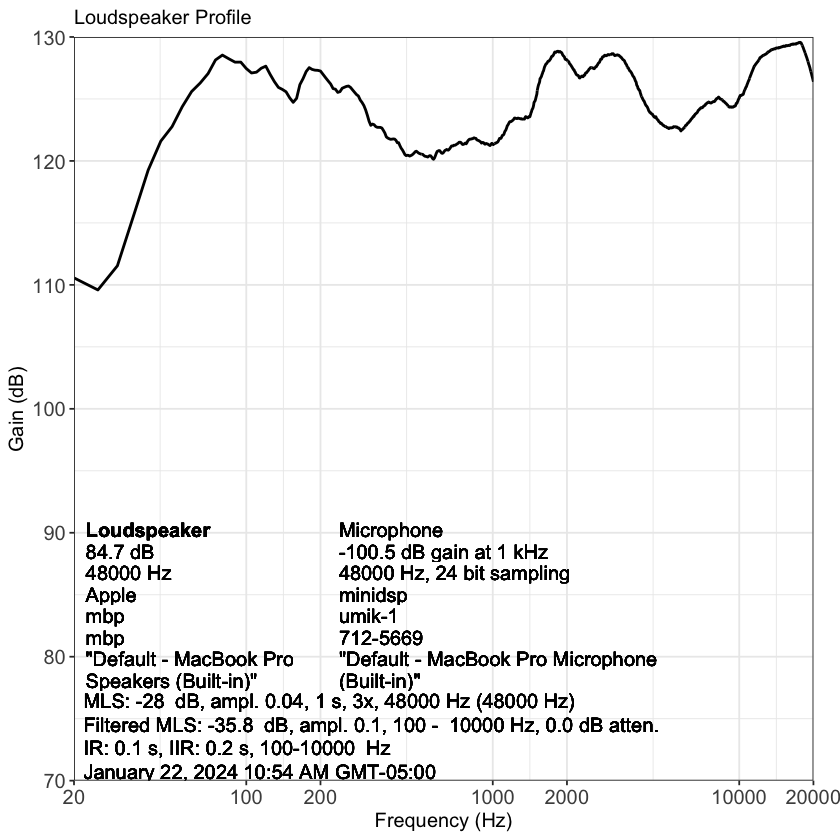

In [5]:
filePath = "enter your json file path here"
jsonFile = fromJSON(filePath, simplifyDataFrame = F)
sound_data = preprocessJSON(jsonFile)
plotComponentIRPSD(jsonFile, sound_data)